In [212]:
import pandas as pd
import numpy as np
import pytz as tz
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from DensityKmeans import DensityKmeans
from matplotlib import pyplot as plt
import mpu
from math import dist
from sklearn.model_selection import train_test_split

In [2]:
df_checkins = pd.read_csv("../dataset/gowalla/gowalla_checkins.csv")
df_friendship = pd.read_csv("../dataset/gowalla/gowalla_friendship.csv")
df_locations = pd.read_csv("../dataset/gowalla/gowalla_spots_subset1.csv")
df_userinfo = pd.read_csv("../dataset/gowalla/gowalla_userinfo.csv")

In [3]:
df_grouped_checkins = df_checkins.groupby(['userid'], as_index=False).count()
filtered_user_ids = df_grouped_checkins[
    (df_grouped_checkins.placeid >= 5) & (df_grouped_checkins.placeid <= 50)].userid.values
df_filtered_checkins = df_checkins[df_checkins.userid.isin(filtered_user_ids)]
df_checkins_locations = pd.merge(df_filtered_checkins[['userid', 'placeid']], df_locations['id'], left_on="placeid",
                                 right_on="id", how="left")
df_checkins_locations = df_checkins_locations.dropna()

In [4]:
df_frequencies = df_checkins_locations.groupby(['userid', 'placeid'])["id"].count().reset_index(name="frequency")
df_frequencies = pd.merge(df_frequencies, df_locations, left_on="placeid", right_on="id", how="left")

In [5]:
df_checkins.head()

,userid,placeid,datetime
0,1338,482954,2011-06-23T02:24:22Z
1,1338,580963,2011-06-22T14:23:03Z
2,1338,365256,2011-06-09T23:29:30Z
3,1338,89504,2011-05-22T15:54:30Z
4,1338,1267135,2011-05-21T16:51:13Z


In [6]:
df_friendship.head()

,userid1,userid2
0,1,63488
1,1,2
2,1,3
3,1,4
4,1,5


In [7]:
df_locations.head()

,id,created_at,lng,lat,photos_count,checkins_count,users_count,radius_meters,highlights_count,items_count,max_items_count,spot_categories
0,8904,2008-12-06T16:28:53Z,-94.607499,39.052318,0,114,21,35,0,10,10,"[{'url': '/categories/89', 'name': 'Craftsman'}]"
1,8932,2008-12-13T02:16:51Z,-97.254356,32.927662,2,67,48,75,0,6,10,"[{'url': '/categories/17', 'name': 'BBQ'}]"
2,8936,2008-12-14T22:08:39Z,-94.591995,39.053318,0,75,46,75,0,10,10,"[{'url': '/categories/103', 'name': 'Theatre'}]"
3,8938,2008-12-15T00:22:49Z,-94.590311,39.052824,38,438,94,50,10,10,10,"[{'url': '/categories/1', 'name': 'Coffee Shop'}]"
4,8947,2008-12-16T23:14:05Z,-122.029631,37.331880,91,3100,1186,200,20,10,10,"[{'url': '/categories/121', 'name': 'Corporate..."


In [8]:
df_userinfo.head()

,id,bookmarked_spots_count,challenge_pin_count,country_pin_count,highlights_count,items_count,photos_count,pins_count,province_pin_count,region_pin_count,state_pin_count,trips_count,friends_count,stamps_count,checkin_num,places_num
0,1,26,59,1,29,18,135,85,0,13,12,2,372,757,1766,756
1,2,36,79,12,117,29,1069,138,0,31,19,7,775,1227,2892,1220
2,3,11,70,1,42,49,149,93,0,7,6,2,100,905,3021,905
3,4,7,51,1,13,29,138,80,0,13,12,1,179,608,1325,613
4,5,34,82,5,62,36,1012,134,0,19,14,2,525,1124,3215,1124


In [9]:
df_frequencies

,userid,placeid,frequency,id,created_at,lng,lat,photos_count,checkins_count,users_count,radius_meters,highlights_count,items_count,max_items_count,spot_categories
0,15,8904,1,8904,2008-12-06T16:28:53Z,-94.607499,39.052318,0,114,21,35,0,10,10,"[{'url': '/categories/89', 'name': 'Craftsman'}]"
1,15,8947,2,8947,2008-12-16T23:14:05Z,-122.029631,37.331880,91,3100,1186,200,20,10,10,"[{'url': '/categories/121', 'name': 'Corporate..."
2,15,9073,1,9073,2009-02-07T01:47:24Z,-122.393725,37.795339,114,2654,1659,100,14,10,10,"[{'url': '/categories/60', 'name': 'Other - Ar..."
3,15,9186,1,9186,2009-02-13T05:07:28Z,-77.036594,38.897638,195,1603,1383,250,19,15,10,"[{'url': '/categories/166', 'name': 'Historic ..."
4,15,9591,1,9591,2009-03-19T14:05:12Z,-122.159772,37.447908,54,1418,525,150,0,10,10,"[{'url': '/categories/230', 'name': 'Apple Sto..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985650,2688969,7450619,9,7450619,2011-06-01T02:02:15Z,-79.978829,32.726278,2,23,3,100,1,1,10,"[{'url': '/categories/48', 'name': 'Resort'}]"
1985651,2688969,7466667,1,7466667,2011-06-04T15:46:55Z,-79.947223,32.662210,0,3,3,100,0,0,10,"[{'url': '/categories/386', 'name': 'Pool / Wa..."
1985652,2688969,7538565,4,7538565,2011-06-23T12:39:31Z,-79.930249,32.778503,0,4,1,75,0,0,10,"[{'url': '/categories/121', 'name': 'Corporate..."
1985653,2688969,7543852,1,7543852,2011-06-24T18:47:19Z,-79.999406,32.784083,0,1,1,75,0,0,10,"[{'url': '/categories/121', 'name': 'Corporate..."


In [10]:
cluster_values = df_frequencies[['lat', 'lng', 'photos_count', 'users_count']]
cluster_values

,lat,lng,photos_count,users_count
0,39.052318,-94.607499,0,21
1,37.331880,-122.029631,91,1186
2,37.795339,-122.393725,114,1659
3,38.897638,-77.036594,195,1383
4,37.447908,-122.159772,54,525
...,...,...,...,...
1985650,32.726278,-79.978829,2,3
1985651,32.662210,-79.947223,0,3
1985652,32.778503,-79.930249,0,1
1985653,32.784083,-79.999406,0,1


In [11]:
scaler = preprocessing.MinMaxScaler()
names = cluster_values.columns
d = scaler.fit_transform(cluster_values)
scaled_df = pd.DataFrame(d)
scaled_df.head()

,0,1,2,3
0,0.721770,0.209073,0.000000,0.002306
1,0.710954,0.129353,0.065515,0.130258
2,0.713868,0.128295,0.082073,0.182208
3,0.720798,0.260154,0.140389,0.151895
4,0.711684,0.128975,0.038877,0.057661


In [12]:
# chart = scaled_df.to_numpy()
# plt.scatter(chart[:, 0], chart[:, 1])

In [117]:
kmeans = KMeans(n_clusters=7, init='k-means++')

# Compute the clusters based on longitude and latitude features
X_sample = scaled_df.sample(frac=0.005)
X_sample = X_sample.to_numpy()
kmeans = kmeans.fit(X_sample)
y = kmeans.labels_
print("silhouette_score ", silhouette_score(X_sample, y, metric='euclidean'))

silhouette_score  0.6713059234365447


In [121]:
kmeans.predict([[0.721770, 0.209073, 0.000000, 0.002306], [0.713868, 0.128295, 0.082073, 0.182208]])

ValueError: X has 3 features, but KMeans is expecting 4 features as input.

In [14]:
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan',
          'navy', 'red', 'blue', 'green']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

In [15]:
# plt.scatter(X_sample[:, 0], X_sample[:, 1], c=vectorizer(y))

In [16]:
densityKmeans = DensityKmeans(X_sample)
densityKmeans.fit()
y = densityKmeans.labels_
y.max()
print("k = 240", " silhouette_score ", silhouette_score(X_sample, y, metric='euclidean'))

k = 240  silhouette_score  0.5479935364211034


In [17]:
densityKmeans.labels_.max()

8

In [18]:
# plt.scatter(X_sample[:, 0], X_sample[:, 1], c=vectorizer(y))

In [19]:
lat1 = 52.2296756
lon1 = 21.0122287
lat2 = 52.406374
lon2 = 16.9251681

# What you were looking for
dist = mpu.haversine_distance((lat1, lon1), (lat2, lon2))
dist

278.45817507541943

In [20]:
location_sample = df_locations.sample(frac=0.005)
location_sample = location_sample.query('-90<lat<90')
location_sample

,id,created_at,lng,lat,photos_count,checkins_count,users_count,radius_meters,highlights_count,items_count,max_items_count,spot_categories
1492992,2784936,2010-08-31T03:00:22Z,103.824978,1.303297,1,4,3,75,0,1,10,"[{'url': '/categories/53', 'name': 'Furniture'}]"
2220786,6893408,2011-02-09T08:01:02Z,106.991607,-6.247866,0,1,1,75,0,0,10,"[{'url': '/categories/217', 'name': 'Other - S..."
1094304,1246061,2010-06-08T19:15:54Z,-81.327660,40.818688,0,1,1,75,0,0,10,"[{'url': '/categories/119', 'name': 'Gas & Aut..."
1875957,6465862,2010-11-20T20:10:29Z,-92.549910,36.367131,2,1,1,75,0,0,10,"[{'url': '/categories/19', 'name': 'Italian'}]"
1678650,5151534,2010-10-08T17:05:41Z,-75.130355,40.309893,0,4,4,75,0,0,10,"[{'url': '/categories/221', 'name': ""Men's App..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1912490,6510438,2010-11-28T18:17:48Z,-70.717087,41.776903,0,2,2,75,0,0,10,"[{'url': '/categories/95', 'name': 'Train Stat..."
1309636,1501169,2010-07-25T15:08:45Z,12.968195,53.221893,1,1,1,100,0,0,10,"[{'url': '/categories/111', 'name': 'Campgroun..."
951717,1079846,2010-05-07T22:51:30Z,-106.588707,35.104938,2,11,10,75,0,0,10,"[{'url': '/categories/433', 'name': 'Starbucks'}]"
1516701,3109486,2010-09-04T17:18:03Z,-2.347813,53.465267,0,3,3,75,0,0,10,"[{'url': '/categories/54', 'name': 'Other - Sh..."


In [53]:
distance_matrix = pd.read_csv('../dataset/gowalla/distance_matrix.csv')
duration_matrix = pd.read_csv('../dataset/gowalla/duration_matrix.csv')

In [54]:
distance_matrix

,origin,Anchorage,Atlanta,Austin,Baltimore,Boston,Chicago,Dallas,Denver,Honolulu,...,Phoenix,Portland,San Antonio,San Diego,San Francisco,San Jose,Seattle,Tampa,Tucson,Washington DC
0,Anchorage,0.00,5471.52,5091.57,5392.82,5416.45,4584.33,4904.83,3851.73,4477.41,...,4092.45,2475.54,5133.22,3941.20,3223.75,3287.92,2307.09,6108.57,4263.73,5405.01
1,Atlanta,5471.52,0.00,1315.28,927.35,1505.11,944.40,1157.42,1945.42,7224.89,...,2554.73,3487.64,1417.45,3034.87,3434.28,3392.03,3503.07,670.37,2472.45,871.28
2,Austin,5091.57,1315.28,0.00,2166.00,2724.01,1571.76,293.52,1240.77,6029.37,...,1396.55,2746.72,118.35,1856.72,2411.91,2356.30,2845.71,1504.82,1270.22,2116.17
3,Baltimore,5392.82,927.35,2166.00,0.00,577.85,973.23,1947.28,2422.32,7792.75,...,3216.98,3788.62,2278.29,3685.28,3941.99,3912.27,3744.10,1370.72,3171.66,57.16
4,Boston,5416.45,1505.11,2724.01,577.85,0.00,1366.63,2490.97,2838.62,8171.81,...,3690.84,4073.04,2838.36,4146.55,4330.34,4307.42,3997.08,1902.93,3662.03,633.85
5,Chicago,4584.33,944.40,1571.76,973.23,1366.63,0.00,1290.15,1474.26,6831.68,...,2332.13,2820.86,1689.58,2781.99,2981.12,2954.45,2786.57,1614.77,2314.78,955.76
6,Dallas,4904.83,1157.42,293.52,1947.28,2490.97,1290.15,0.00,1064.41,6094.11,...,1422.04,2622.84,406.54,1899.38,2380.88,2330.39,2700.59,1474.58,1324.24,1900.46
7,Denver,3851.73,1945.42,1240.77,2422.32,2838.62,1474.26,1064.41,0.00,5371.40,...,941.98,1578.21,1289.91,1339.39,1523.82,1491.31,1639.91,2446.40,990.98,2394.54
8,Honolulu,4477.41,7224.89,6029.37,7792.75,8171.81,6831.68,6094.11,5371.40,0.00,...,4674.19,4173.02,5966.85,4195.13,3851.23,3880.53,4309.01,7534.16,4772.30,7765.83
9,Houston,5260.73,1126.72,235.70,2010.47,2578.59,1510.62,362.26,1412.40,6263.11,...,1631.41,2949.23,304.77,2092.41,2641.46,2586.65,3038.45,1271.24,1505.92,1958.40


In [55]:
duration_matrix

,origin,Anchorage,Atlanta,Austin,Baltimore,Boston,Chicago,Dallas,Denver,Honolulu,...,Phoenix,Portland,San Antonio,San Diego,San Francisco,San Jose,Seattle,Tampa,Tucson,Washington DC
0,Anchorage,0.000,1094.304,1018.314,1078.564,1083.290,916.866,980.966,770.346,895.482,...,818.490,495.108,1026.644,788.240,644.750,657.584,461.418,1221.714,852.746,1081.002
1,Atlanta,1094.304,0.000,263.056,185.470,301.022,188.880,231.484,389.084,1444.978,...,510.946,697.528,283.490,606.974,686.856,678.406,700.614,134.074,494.490,174.256
2,Austin,1018.314,263.056,0.000,433.200,544.802,314.352,58.704,248.154,1205.874,...,279.310,549.344,23.670,371.344,482.382,471.260,569.142,300.964,254.044,423.234
3,Baltimore,1078.564,185.470,433.200,0.000,115.570,194.646,389.456,484.464,1558.550,...,643.396,757.724,455.658,737.056,788.398,782.454,748.820,274.144,634.332,11.432
4,Boston,1083.290,301.022,544.802,115.570,0.000,273.326,498.194,567.724,1634.362,...,738.168,814.608,567.672,829.310,866.068,861.484,799.416,380.586,732.406,126.770
5,Chicago,916.866,188.880,314.352,194.646,273.326,0.000,258.030,294.852,1366.336,...,466.426,564.172,337.916,556.398,596.224,590.890,557.314,322.954,462.956,191.152
6,Dallas,980.966,231.484,58.704,389.456,498.194,258.030,0.000,212.882,1218.822,...,284.408,524.568,81.308,379.876,476.176,466.078,540.118,294.916,264.848,380.092
7,Denver,770.346,389.084,248.154,484.464,567.724,294.852,212.882,0.000,1074.280,...,188.396,315.642,257.982,267.878,304.764,298.262,327.982,489.280,198.196,478.908
8,Honolulu,895.482,1444.978,1205.874,1558.550,1634.362,1366.336,1218.822,1074.280,0.000,...,934.838,834.604,1193.370,839.026,770.246,776.106,861.802,1506.832,954.460,1553.166
9,Houston,1052.146,225.344,47.140,402.094,515.718,302.124,72.452,282.480,1252.622,...,326.282,589.846,60.954,418.482,528.292,517.330,607.690,254.248,301.184,391.680


In [70]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="geoapiExercises")
Latitude = "51.228737"
Longitude = "2.926161"

location = geolocator.reverse(Latitude + "," + Longitude)

address = location.raw['address']
address.get('state')

'West-Vlaanderen'

In [58]:
df_frequencies

,userid,placeid,frequency,id,created_at,lng,lat,photos_count,checkins_count,users_count,radius_meters,highlights_count,items_count,max_items_count,spot_categories
0,15,8904,1,8904,2008-12-06T16:28:53Z,-94.607499,39.052318,0,114,21,35,0,10,10,"[{'url': '/categories/89', 'name': 'Craftsman'}]"
1,15,8947,2,8947,2008-12-16T23:14:05Z,-122.029631,37.331880,91,3100,1186,200,20,10,10,"[{'url': '/categories/121', 'name': 'Corporate..."
2,15,9073,1,9073,2009-02-07T01:47:24Z,-122.393725,37.795339,114,2654,1659,100,14,10,10,"[{'url': '/categories/60', 'name': 'Other - Ar..."
3,15,9186,1,9186,2009-02-13T05:07:28Z,-77.036594,38.897638,195,1603,1383,250,19,15,10,"[{'url': '/categories/166', 'name': 'Historic ..."
4,15,9591,1,9591,2009-03-19T14:05:12Z,-122.159772,37.447908,54,1418,525,150,0,10,10,"[{'url': '/categories/230', 'name': 'Apple Sto..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985650,2688969,7450619,9,7450619,2011-06-01T02:02:15Z,-79.978829,32.726278,2,23,3,100,1,1,10,"[{'url': '/categories/48', 'name': 'Resort'}]"
1985651,2688969,7466667,1,7466667,2011-06-04T15:46:55Z,-79.947223,32.662210,0,3,3,100,0,0,10,"[{'url': '/categories/386', 'name': 'Pool / Wa..."
1985652,2688969,7538565,4,7538565,2011-06-23T12:39:31Z,-79.930249,32.778503,0,4,1,75,0,0,10,"[{'url': '/categories/121', 'name': 'Corporate..."
1985653,2688969,7543852,1,7543852,2011-06-24T18:47:19Z,-79.999406,32.784083,0,1,1,75,0,0,10,"[{'url': '/categories/121', 'name': 'Corporate..."


In [95]:
# states = ['origin', 'Alaska', 'Atlanta', 'Texas', 'Maryland', 'Massachusetts', 'Illinois', 'Texas', 'Denver', 'Hawaii',
#           'Texas', 'Indiana', 'Alabama', 'Nevada', 'California', 'Tennessee', 'Florida', 'Louisiana', 'New York',
#           'New Jersey', 'California', 'Pennsylvania', 'Arizona', 'Oregon', 'Texas', 'California', 'San Francisco',
#           'California', 'Washington', 'Florida', 'Arizona', 'Washington']
#
# new_frequency = pd.DataFrame()
# for freq in df_frequencies.iterrows():
#     location = geolocator.reverse(str(freq[1].lat) + "," + str(freq[1].lng))
#     state = location.raw['address'].get('state')
#     if state in states:
#         freq[1]['state'] = state
#         new_frequency = new_frequency.append(freq[1])
#
# new_frequency

/tmp/ipykernel_74079/1849240842.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_frequency = new_frequency.append(freq[1])
/tmp/ipykernel_74079/1849240842.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_frequency = new_frequency.append(freq[1])
/tmp/ipykernel_74079/1849240842.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_frequency = new_frequency.append(freq[1])
/tmp/ipykernel_74079/1849240842.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_frequency = new_frequency.append(freq[1])
/tmp/ipykernel_74079/1849240842.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

KeyboardInterrupt: 

In [219]:
# chart = new_scaled_df.to_numpy()
# plt.scatter(chart[:, 0], chart[:, 1])

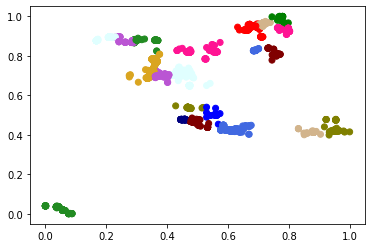

In [149]:
# plt.scatter(new_scaled_df.to_numpy()[:, 0], new_scaled_df.to_numpy()[:, 1], c=vectorizer(y))